notice(2): Group "all" created containing 125 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 125
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:05 | Step 100000 / 100000 | TPS 17423.6 | ETA 00:00:00
Average TPS: 17419.8
---------
-- Neighborlist stats:
7768 normal updates / 1001 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 21 / n_neigh_avg: 7.152
shortest rebuild period: 2
-- Cell list stats:
Dimension: 3, 3, 3
n_min    : 1 / n_max: 11 / n_avg: 4.62963
** run complete **


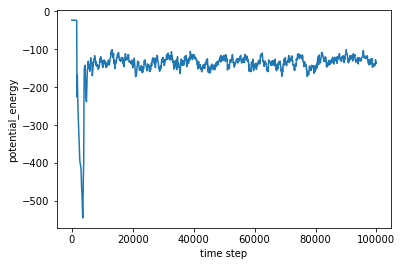

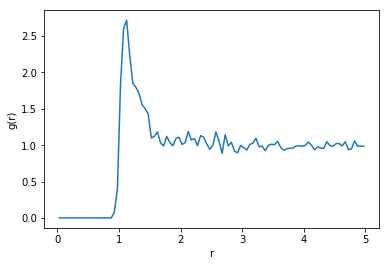

In [8]:
import hoomd
import hoomd.md
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from freud import parallel, box, density
import gsd
import gsd.hoomd
import gsd.fl
parallel.setNumThreads(4)


def plot_rdf(file, frames, rmax, label):
    # frames is the number of frames you want to average over starting from
    # the last frame
    rdf = density.RDF(rmax=rmax, dr=0.05)
    f = gsd.fl.GSDFile(file, 'rb')
    t = gsd.hoomd.HOOMDTrajectory(f)
    for i in range(1, frames):
        sim_box = t[-i].configuration.box
        fbox = box.Box(Lx=sim_box[0], Ly=sim_box[1], Lz=sim_box[2])
        pos = t[-i].particles.position
        rdf.accumulate(fbox, pos, pos)
                       
    r_avg = np.copy(rdf.getR())
    y_avg = np.copy(rdf.getRDF())
    plt.plot(r_avg, y_avg, label=label)
    plt.ylabel("g(r)")
    plt.xlabel("r")


#these four lines get the basic infrastructure set up
hoomd.context.initialize('--mode=cpu')
hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=2.),n=5)
nl = hoomd.md.nlist.cell()
all = hoomd.group.all()

#Investigating interactions is a lot of Project 2
#Therefore, lots of your work will focus on modifications and additions to these two lines
lj = hoomd.md.pair.lj(r_cut=2.5,nlist=nl)
lj.pair_coeff.set('A','A',epsilon=1,sigma=1)

#Another component of Project 2 is investigating which integrators make sense to use,
#how they influence the results, and what 'extra work' you may need to do to use them well
hoomd.md.integrate.mode_standard(dt=0.005)
hoomd.md.integrate.nvt(group=all, kT = 1.0, tau = 1.0)

hoomd.analyze.log(filename="log",quantities=['potential_energy'],period=100,overwrite=True)
#we will want to record the particle trajectories using a gsd file
hoomd.dump.gsd("trajectory.gsd", period=1e3, group=all, overwrite=True)
hoomd.run(1e5)


# Here we will read in the log file
data = np.genfromtxt(fname='log', skip_header=True)

# Now we use the first col as the x and the 2nd col as the y
plt.plot(data[:,0], data[:,1])

plt.xlabel('time step')
plt.ylabel('potential_energy')
plt.show()

# Plots the average rdf over the last 10 frames, with an r_cut of 5.0
plot_rdf('trajectory.gsd', 10, 5.0, "kT = 1.0")